In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM,GRU
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D,MaxPooling1D,GlobalAveragePooling1D,Reshape
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [3]:
df = pd.read_csv("../data/phase2_train.csv", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)
print(df['label'].value_counts())

(3004066, 4)
0    2924512
1      79554
Name: label, dtype: int64


In [4]:
data= df[["value","label"]]
a=data[440000:500000]##点集2400000:2500000,1100000:1200000
print(a['label'].value_counts())
normal=a[a['label']== 0]#55000:100000
normal=normal["value"]
test=data[508000:512000]
print(test['label'].value_counts())
test_label=test['label']
test=np.array(test['value'])
train=np.array(normal)
timesquence=20
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
print("train",train.shape)
trim=len(test)%timesquence
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)
print("test",test.shape)

0    59838
1      162
Name: label, dtype: int64
0    3520
1     480
Name: label, dtype: int64
train (2991, 20, 1)
test (200, 20, 1)


In [50]:
metric = 'mean_absolute_error'
model = Sequential()
model.add(GRU(units=32, activation='relu', input_shape=(20, 1), return_sequences=True))
#model.add(GRU(units=16,activation='relu', return_sequences=True))
model.add(Dropout(0.5))  
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 20, 32)            3264      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 20, 1)             33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
metric = 'mean_absolute_error'
model = Sequential()
model.add(GRU(units=32, activation='relu', input_shape=(20, 1), return_sequences=True))
model.add(GRU(units=16,activation='relu', return_sequences=True))
model.add(GRU(units=8,activation='relu', return_sequences=True))
model.add(Dropout(0.5))  
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 20, 32)            3264      
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 16)            2352      
_________________________________________________________________
gru_3 (GRU)                  (None, 20, 8)             600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 8)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 20, 1)             9         
Total params: 6,225
Trainable params: 6,225
Non-trainable params: 0
_________________________________________________________________
None


In [142]:
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
x = Conv1D(filters=n_filters,
               kernel_size=filter_width,
             padding='causal',
              activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

model = Model(history_seq, pred_seq_train)
model.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
dense_18 (Dense)             (None, None, 128)         4224      
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
dense_19 (Dense)             (None, None, 1)           129       
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1)           0         
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________

In [6]:

history=model.fit(train, train,
                  batch_size=30,#30,30
                   epochs=10,#13, 10
                    validation_data=(test, test))



Train on 2991 samples, validate on 200 samples
Epoch 1/10
2991/2991 [==============================] - 36s 12ms/step - loss: 1.1467 - mean_absolute_error: 1.1467 - val_loss: 0.6250 - val_mean_absolute_error: 0.6250
Epoch 2/10
2991/2991 [==============================] - 19s 6ms/step - loss: 0.7658 - mean_absolute_error: 0.7658 - val_loss: 0.3155 - val_mean_absolute_error: 0.3155
Epoch 3/10
2991/2991 [==============================] - 20s 7ms/step - loss: 0.5787 - mean_absolute_error: 0.5787 - val_loss: 0.2893 - val_mean_absolute_error: 0.2893
Epoch 4/10
2991/2991 [==============================] - 20s 7ms/step - loss: 0.5201 - mean_absolute_error: 0.5201 - val_loss: 0.2739 - val_mean_absolute_error: 0.2739
Epoch 5/10
2991/2991 [==============================] - 20s 7ms/step - loss: 0.4750 - mean_absolute_error: 0.4750 - val_loss: 0.1803 - val_mean_absolute_error: 0.1803
Epoch 6/10
2991/2991 [==============================] - 20s 7ms/step - loss: 0.3942 - mean_absolute_error: 0.3942 - v

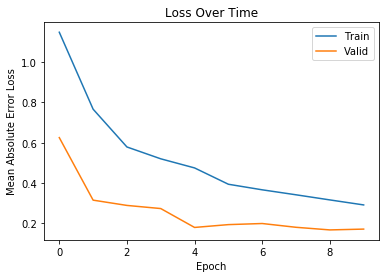

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [8]:
test_pred = model.predict(test)
print(test_pred.shape)
print(test[0:20])
print("-------------------------")
print(test_pred[0:10])


(200, 20, 1)
[[[1.75      ]
  [1.85000002]
  [1.85000002]
  [1.85000002]
  [1.79999995]
  [2.0999999 ]
  [1.79999995]
  [1.60000002]
  [1.79999995]
  [1.89999998]
  [1.70000005]
  [1.89999998]
  [1.60000002]
  [1.85000002]
  [1.89999998]
  [1.75      ]
  [2.04999995]
  [1.85000002]
  [1.64999998]
  [1.89999998]]

 [[1.95000005]
  [1.85000002]
  [1.70000005]
  [1.89999998]
  [1.85000002]
  [1.85000002]
  [2.0999999 ]
  [1.79999995]
  [1.85000002]
  [1.85000002]
  [1.85000002]
  [1.79999995]
  [1.85000002]
  [1.85000002]
  [1.75      ]
  [1.79999995]
  [1.85000002]
  [1.75      ]
  [1.89999998]
  [2.        ]]

 [[1.70000005]
  [1.79999995]
  [1.89999998]
  [1.64999998]
  [2.75      ]
  [1.79999995]
  [1.75      ]
  [1.89999998]
  [1.79999995]
  [1.85000002]
  [1.75      ]
  [1.79999995]
  [1.95000005]
  [1.89999998]
  [1.70000005]
  [1.79999995]
  [1.64999998]
  [1.70000005]
  [1.95000005]
  [1.75      ]]

 [[1.64999998]
  [2.        ]
  [1.85000002]
  [1.75      ]
  [2.0999999 ]
  [1.7

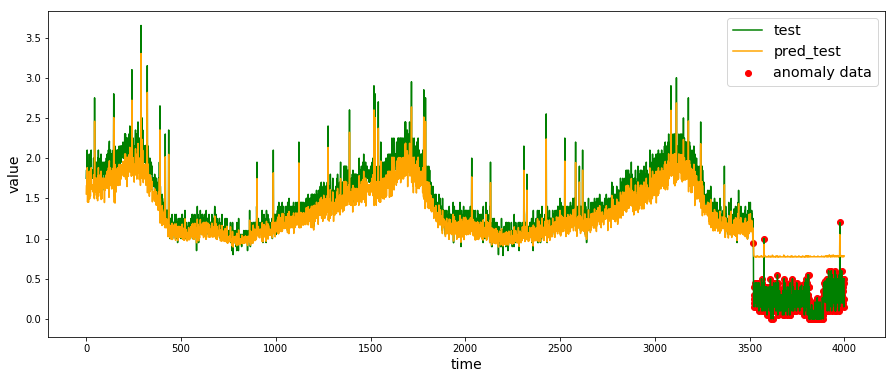

In [9]:
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')

for i in range(4000):
    if test_label.iloc[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')

In [33]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[3.19480896e-04 3.36408619e-04 4.54604626e-04 ... 7.83534527e-01
 7.83534527e-01 7.83534527e-01]


In [34]:
print(PAscores[1000])

0.07531297207064447


In [35]:
PAcutoff=int(0.99*len(PAscores))
PAthreshold=PAscores[PAcutoff]
print(PAscores[PAcutoff])

0.7232100479304371


In [36]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [37]:
normal_rela_erro=0.005
#集体集检测
timestep=15
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)


[0.50408572 0.59123963 0.626665   0.65023071 0.66431302 0.66512156
 0.66636002 0.66912436 0.67600542 0.68101621 0.72726494 0.72825694
 0.73917586 0.77180564 0.77442896 0.77847159 0.80040634 0.80284697
 0.80750668 0.81782943 0.8191911  0.82931674 0.82968253 0.846017
 0.8471216  0.85727787 0.87019813 0.87123901 0.88725126 0.90643001
 0.91283995 0.91493589 0.9263593  0.92672014 0.92885089 0.93277746
 0.96442306 0.9651261  0.97159886 0.97189391 0.97541201 0.9886694
 0.99567711 0.99596977 0.99705762 1.00187004 1.00586927 1.02942371
 1.03412092 1.03573501 1.03955925 1.04295754 1.04557037 1.04807031
 1.05043089 1.0540849  1.06259483 1.07366419 1.08577096 1.08612442
 1.08706313 1.09005952 1.09598279 1.1001265  1.1004867  1.10299337
 1.10760224 1.10815775 1.10946822 1.111426   1.112571   1.12003338
 1.12344909 1.12707222 1.1417737  1.14731324 1.17871624 1.18203223
 1.1858815  1.19362366 1.19850731 1.2127974  1.21654367 1.22660434
 1.23371089 1.24502671 1.25858974 1.26146924 1.26837718 1.2755506

In [38]:
CAcutoff=int(0.91*len(CAscores))
CAthreshold=CAscores[CAcutoff]
print(CAscores[CAcutoff])

6.669452734292547


In [39]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [40]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

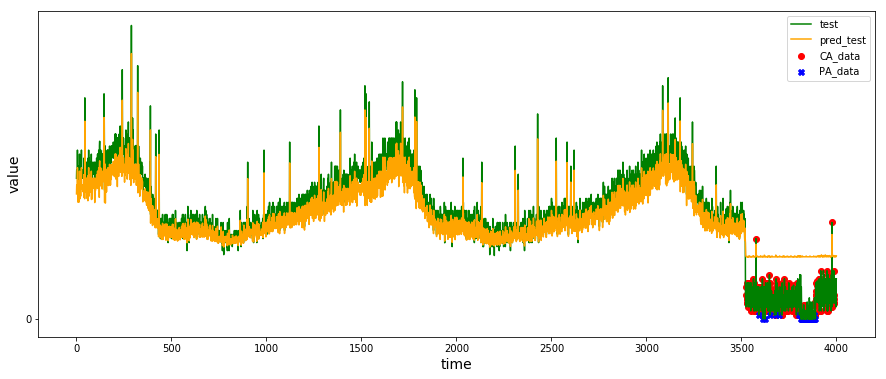

In [41]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [42]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [43]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

CA: 349
PA: 39
ROC_AUC score:90.416667%
PR-AUC score:91.566667%


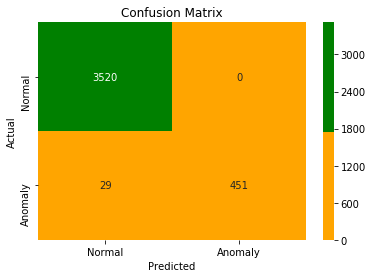

In [32]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)